# TP2
## 0. Algunas pruebas

In [3]:
# Common libraries
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [4]:
# Set image repo
ImgFolder = ".\\"

# Quick function to plot to matplotlib
def rgbPlot(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()
    return

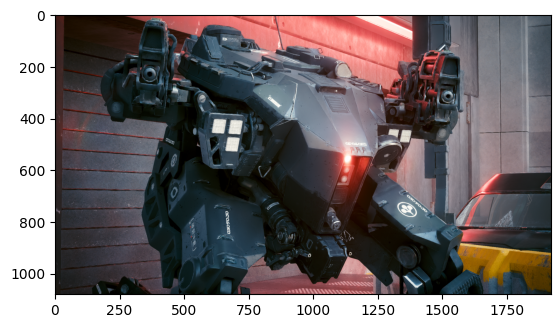

In [5]:
img = cv.imread(ImgFolder + 'mech.png' )
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

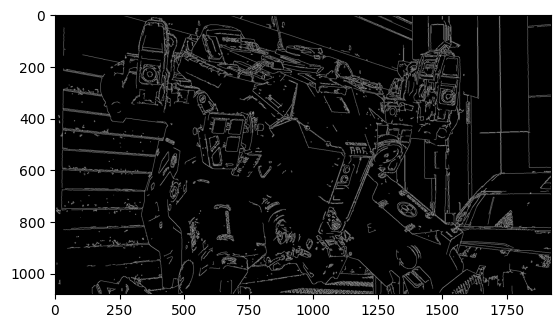

In [6]:
edges = cv.Canny(img, threshold1=100, threshold2=255)
plt.imshow(cv.cvtColor(edges, cv.COLOR_BGR2RGB))

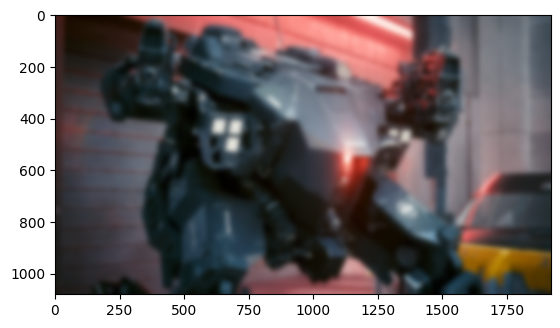

In [7]:
kx = cv.getGaussianKernel(125,10)
ky = cv.getGaussianKernel(125,10)
k = kx * ky.T
gauss = np.zeros(img.shape)
gauss = cv.sepFilter2D(img, ddepth=-1, kernelX=kx, kernelY=ky)
plt.imshow(cv.cvtColor(gauss, cv.COLOR_BGR2RGB))

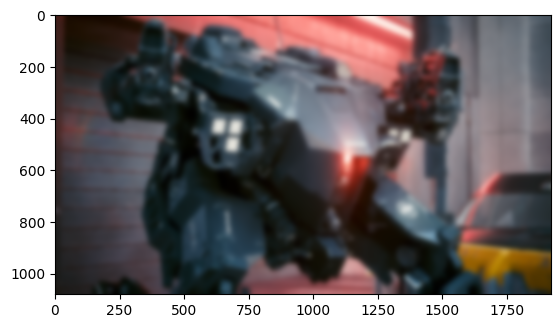

In [8]:
plt.imshow(cv.cvtColor(cv.GaussianBlur(img,(125,125),sigmaX=10),cv.COLOR_BGR2RGB))

## Parte 1 - Filtro gaussiano en el dominio de la frecuencia
Implementar la función create_gauss_filter(h,w,k_size,sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de fourier

In [34]:
# Utility functions

# Get logarithmic representation of an spectral image
def fft2_mod(image):
  return 20*np.log(np.abs(image))

# Get the indexes of the center point of an image.
def getCenter(img):
    center = np.floor((np.array(img.shape)/2.0)).astype('uint')
    return np.array([center[0],center[1]],dtype='uint')

# Place image at the center of a canvas array
def placeOnCenter(canvas,img, offsetXY = [0,0]):
    diff = np.clip(np.floor((img.shape[0] - canvas.shape[0]) / 2.0),a_min=0,a_max=None).astype('uint')
    sx = slice(diff,np.clip(img.shape[0]-diff,0,canvas.shape[0]+diff))
    diff = np.clip(np.floor((img.shape[1] - canvas.shape[1]) / 2.0),a_min=0,a_max=None).astype('uint')
    sy = slice(diff,np.clip(img.shape[1]-diff,0,canvas.shape[1]+diff))
    img = img[sx,sy,...]
    top_corners = (getCenter(canvas) - getCenter(img) + np.array(offsetXY)).clip(0,np.iinfo('uint').max).astype('uint')
    sx = slice(top_corners[0], (top_corners[0] + img.shape[0]).clip(0,canvas.shape[0]))
    sy = slice(top_corners[1], (top_corners[1] + img.shape[1]).clip(0,canvas.shape[1]))
    # TODP: slice img when out of bounds by offset.
    canvas[sx,sy,...] = img
    return canvas

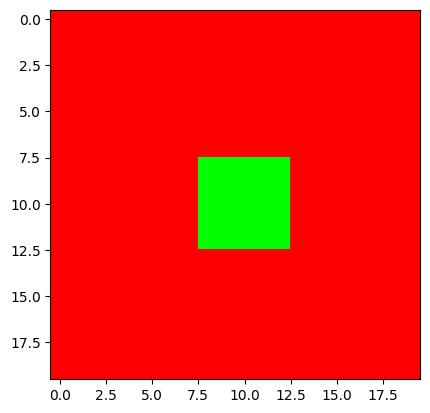

In [35]:
# Test those functions

box1 = (np.ones((20,20))+254)
box2 = (np.ones((5,5))+254)
red_box = cv.merge((np.zeros(box1.shape),np.zeros(box1.shape),box1)).astype('uint8')
green_box = cv.merge((np.zeros(box2.shape),box2,np.zeros(box2.shape))).astype('uint8')
rgbPlot(placeOnCenter(red_box,green_box))

In [11]:
def create_gauss_filter(h, w, k_size = 5, sigma = 0.5):
    canvas = np.zeros((h,w))
    k_1d = cv.getGaussianKernel(k_size,sigma)
    k_2d = k_1d * k_1d.T
    filter_spatial = placeOnCenter(canvas,k_2d)
    filter_spectral = np.fft.fft2(filter_spatial)
    return filter_spatial,filter_spectral

### 1.1 Representaciones de los filtros

Text(0.5, 0.98, '30x30, k = (7,7), sigma = 5')

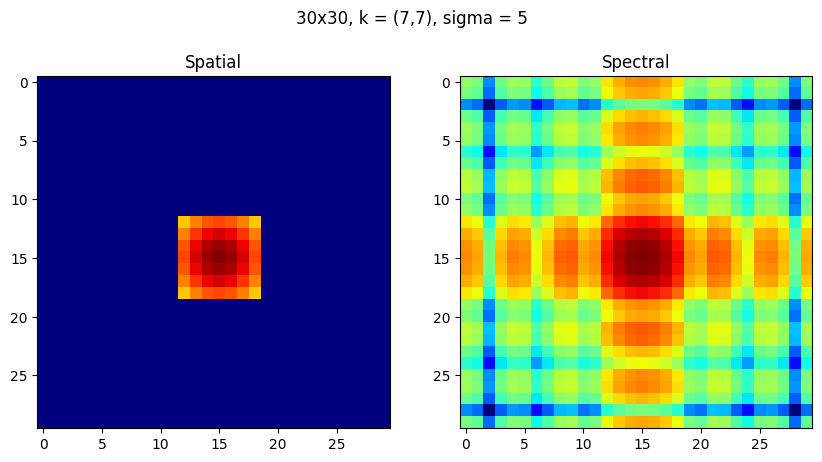

In [12]:
gauss_space, gauss_ft = create_gauss_filter(30,30,k_size=7,sigma=5)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(gauss_space,cmap='jet')
ax[0].set_title('Spatial')
ax[1].imshow(fft2_mod(np.fft.fftshift(gauss_ft)),cmap='jet')
ax[1].set_title('Spectral')
fig.suptitle('30x30, k = (7,7), sigma = 5')

Text(0.5, 0.98, '30x30, k = (15,15), sigma = 15')

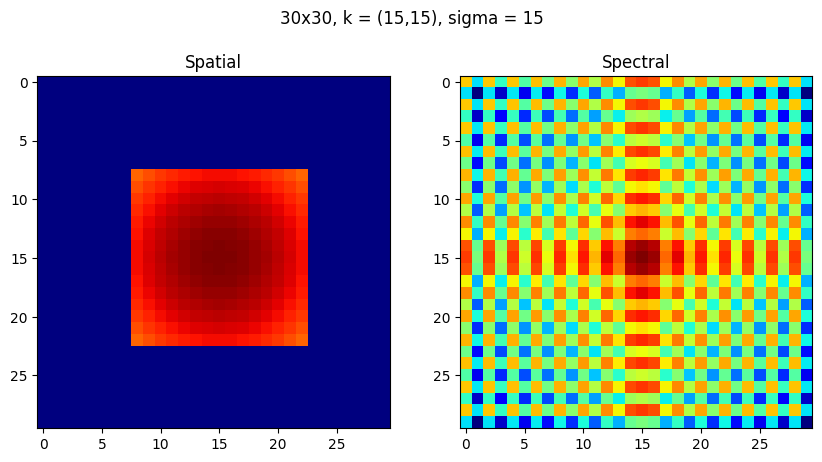

In [13]:
gauss_space, gauss_ft = create_gauss_filter(30,30,k_size=15,sigma=15)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(gauss_space,cmap='jet')
ax[0].set_title('Spatial')
ax[1].imshow(fft2_mod(np.fft.fftshift(gauss_ft)),cmap='jet')
ax[1].set_title('Spectral')
fig.suptitle('30x30, k = (15,15), sigma = 15')

Text(0.5, 0.98, '30x30, k = (15,15), sigma = 0.5')

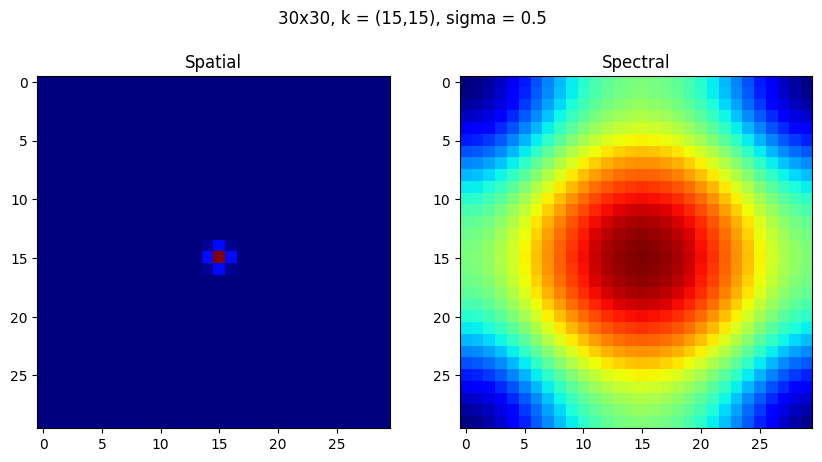

In [14]:
gauss_space, gauss_ft = create_gauss_filter(30,30,k_size=15,sigma=0.5)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(gauss_space,cmap='jet')
ax[0].set_title('Spatial')
ax[1].imshow(fft2_mod(np.fft.fftshift(gauss_ft)),cmap='jet')
ax[1].set_title('Spectral')
fig.suptitle('30x30, k = (15,15), sigma = 0.5')

### 1.2 Filtro sobre imagen

In [15]:
img = cv.imread(ImgFolder + 'mech.png', 
                cv.IMREAD_GRAYSCALE 
                )

Text(0.5, 1.0, 'Spectral')

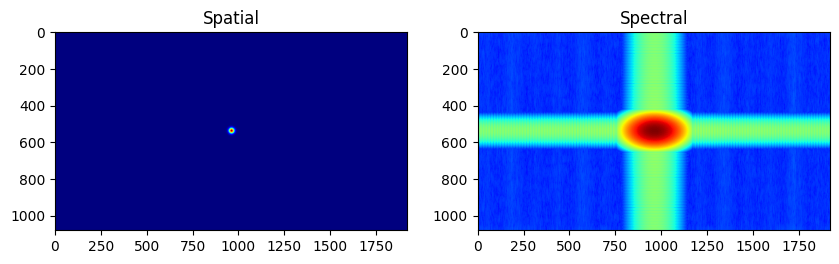

In [16]:
gauss_space, gauss_ft = create_gauss_filter(img.shape[0],img.shape[1],k_size=127,sigma=10)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(gauss_space,cmap='jet')
ax[0].set_title('Spatial')
ax[1].imshow(fft2_mod(np.fft.fftshift(gauss_ft)),cmap='jet')
ax[1].set_title('Spectral')

Text(0.5, 1.0, 'Frequency domain gaussian blur')

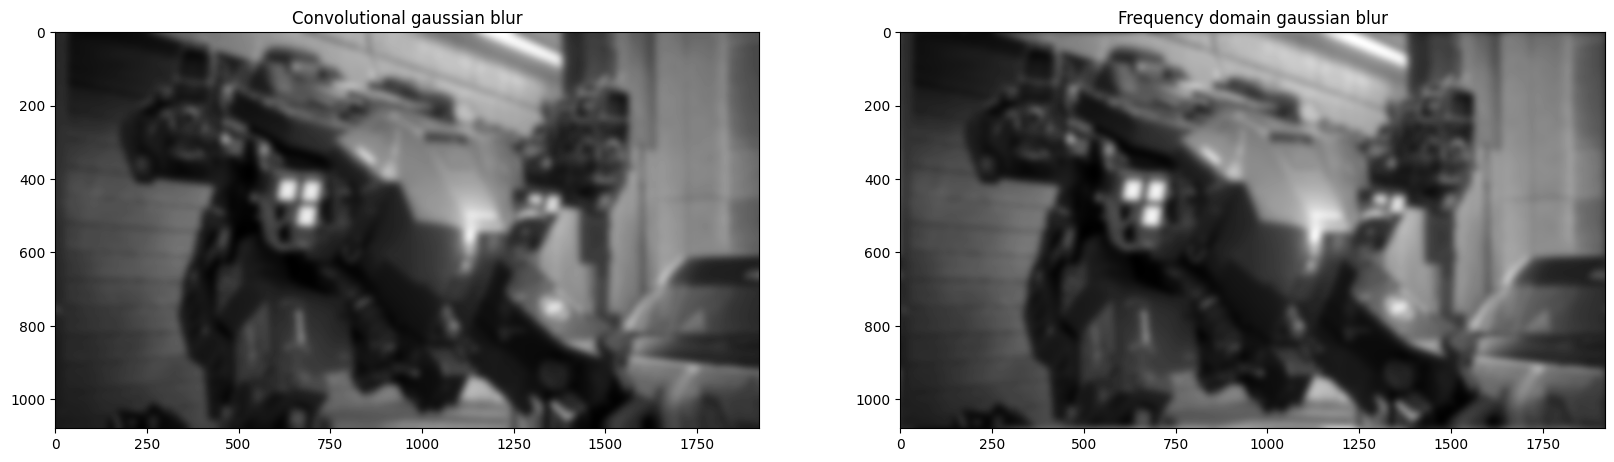

In [17]:
img_fft = np.fft.fft2(img)
filtered = img_fft * gauss_ft

img_gauss_ft = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
img_gauss = cv.GaussianBlur(img,(127,127),sigmaX=10)

fig, ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(img_gauss,cmap='gray')
ax[0].set_title('Convolutional gaussian blur')
ax[1].imshow(img_gauss_ft,cmap='gray')
ax[1].set_title('Frequency domain gaussian blur')


## Parte 2 - Comparación entre blurs - Image Quality Measure
En el paper Image Sharpness Measure for Blurred Imagines in Frequency se propone un método para calcular el grado de _blur_ de una imagen: _Image Quality Measure (FM)_. En este caso, lo uso para comprar los dos tipos de blur. 

In [18]:
def imageQualityMeasure(img):
    f = np.fft.fft2(img)
    fc = np.fft.ifftshift(f)
    af = abs(fc)
    M = np.max(fc)
    Th = len(fc[fc>(M/1000.0)])
    return Th/(img.shape[0]*img.shape[1])

(-0.5, 1919.5, 1079.5, -0.5)

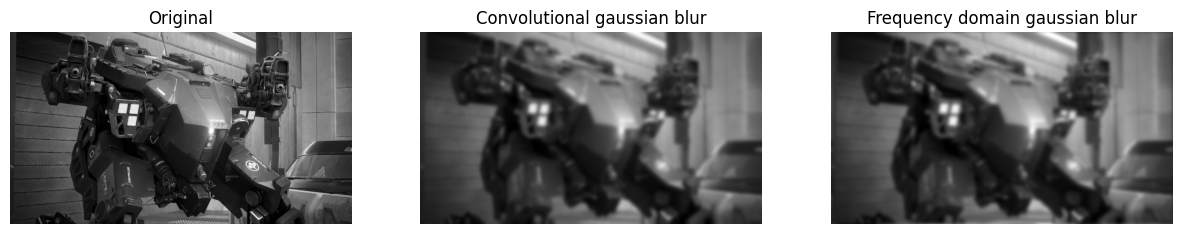

In [19]:
fig, ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original')
ax[0].axis("off")
ax[1].imshow(img_gauss,cmap='gray')
ax[1].set_title('Convolutional gaussian blur')
ax[1].axis("off")
ax[2].imshow(img_gauss_ft,cmap='gray')
ax[2].set_title('Frequency domain gaussian blur')
ax[2].axis("off")

In [20]:
print('The image quality measure for the original image is', imageQualityMeasure(img))
print('Convolutional Gaussian blur quality is', imageQualityMeasure(img_gauss))
print('Frequency domain Gaussian blur quality is', imageQualityMeasure(img_gauss_ft))

The image quality measure for the original image is 0.0015533371913580246
Convolutional Gaussian blur quality is 0.0004422260802469136
Frequency domain Gaussian blur quality is 0.00043643904320987654


Claramente, las imagenes suavizadas tienen peor puntaje de calidad. Además, los dos tipos de suavizados son practicamente iguales, aunque se podría decir que el convolucional es un 5.787037037037056e-06 mejor. Por otro lado, por lo menos con esta imagen, esta métrica no pareciera del todo buena considerando que en el _paper_ una "buena" imagen tiene un FM de 0.018.

## Parte 3 - Comparación entre suavizados - Gray-level variance
Una imagen suavizada puede considerarse una imagen fuera de foco, y un método popular para medir el foco en aplicaciones de autofoco es el la varianza del nivel de grises. Se define:

$$
\varPhi_{x,y} = \sum_{(i,j) \epsilon \Omega(x,y)} (I(i,j)-\mu)^2
$$

Donde $\mu$ es la media del nivel de gris en $\Omega(x,y)$. Simplemente, la varianza en alguna región de interes. Cuanta mayor varianza, más enfocada la imagen.

In [21]:
print("Gray variance for whole original image is", np.var(img))
print("Convolutional Gaussian blur variance:",np.var(img_gauss))
print("Frequency domain Gaussian blur variance:",np.var(img_gauss_ft))
print("Gray level variance for more aggressive Gaussian Blur:", np.var(cv.GaussianBlur(img,(127,127),sigmaX=30)))

Gray variance for whole original image is 2727.909683464661
Convolutional Gaussian blur variance: 2197.245425310663
Frequency domain Gaussian blur variance: 2169.4009367197823


Gray level variance for more aggressive Gaussian Blur: 1796.66563437265


Se mantiene la premisa mencionada: mayor varianza, mejor foco. Contrario al método anterior, este se usa para algoritmos de optimización de autofoco con lo que cada valor se analiza relativo a los demás. Nuavamente, parece que el _Gaussian blur_ por dominio de frecuencia es más agresivo y suaviza más que el convolucional.